<a href="https://colab.research.google.com/github/joe-granick/CS462/blob/main/autograd_and_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure you fill your name and NetID below:

In [ ]:
NAME = "Joseph Granick"
NET_ID = "jgranick"

---

# torch.autograd and torch.nn

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. Deriving and implementing the gradient of even a very simple model can be time-consuming and potentially error-prone. With `torch.autograd`, you only need to implement the forward pass of your model, and PyTorch will handle the backward pass.

The `torch.nn` package defines a set of Modules, which you can think of as a neural network layer that has produces output from input and may have some trainable weights.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here.
If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better.

1. Part I, Preparation: We will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors with autograd.
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define an arbitrary neural network architecture.
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a fully-connected and convolutional network very conveniently.

Here is a table of comparison:

| API             | Flexibility | Convenience |
|-----------------|-------------|-------------|
| Barebone        | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

## Install starter code
We have implemented some utility functions for this exercise in the [`coutils` package](https://github.com/yfw/starter-code). Run this cell to download and install it.

In [1]:
!pip install git+https://github.com/yfw/starter-code

  Cloning https://github.com/yfw/starter-code to /tmp/pip-req-build-hflydtke
  Running command git clone --filter=blob:none --quiet https://github.com/yfw/starter-code /tmp/pip-req-build-hflydtke
  Resolved https://github.com/yfw/starter-code to commit 9a6269738ba0094d0bd09aea4cc21747b965c6d1
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10270 sha256=8eb00fe3d00cd0e4734b1f270b3f525de2e68d8b35dc027df2ed4077bae0eda8
  Stored in directory: /tmp/pip-ephem-wheel-cache-lh6_wsxr/wheels/22/ab/9b/770e4a76259668911f75f1ac233b74d26e0598f3f826408192
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook.

In [2]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████| 170M/170M [00:02<00:00, 75.6MB/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [4]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


Before we start, we define the flatten function for convenience.

In [5]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers for CIFAR classification.
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely, if `x` is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of `x` with respect to the scalar loss at the end.

### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [6]:
def two_layer_fc(x, params):
  """
  A fully-connected neural networks; the architecture is:
  fully connected layer -> ReLU -> fully connected layer.
  Note that this function only defines the forward pass;
  PyTorch will take care of the backward pass for us.

  The input to the network will be a minibatch of data, of shape
  (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
  and the output layer will produce scores for K classes.

  Inputs:
  - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
    input data.
  - params: A list [w1, b1, w2, b2] of PyTorch Tensors giving weights and biases for the network;
    w1 has shape (D, H), b1 has shape (H,), w2 has shape (H, K), and b2 has shape (K,).

  Returns:
  - scores: A PyTorch Tensor of shape (N, K) giving classification scores for
    the input data x.
  """
  # first we flatten the image
  x = flatten(x)  # shape: [batch_size, C x H x W]

  w1, b1, w2, b2 = params

  # Forward pass: compute predicted y using operations on Tensors. If w1 and
  # w2 have requires_grad=True, then operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  # Note that F.linear(x, w, b) is equivalent to x.mm(w.t()) + b
  # For ReLU, you can also use `.clamp(min=0)`, equivalent to `F.relu()`
  x = F.relu(F.linear(x, w1.T, b1))
  x = F.linear(x, w2.T, b2)
  return x


def two_layer_fc_test():
  hidden_layer_size = 42
  x = torch.zeros((64, 3, 16, 16), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  w1 = torch.zeros((3*16*16, hidden_layer_size), dtype=dtype)
  b1 = torch.zeros((hidden_layer_size,), dtype=dtype)
  w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
  b2 = torch.zeros((10,), dtype=dtype)
  scores = two_layer_fc(x, [w1, b1, w2, b2])
  print('Output size:', list(scores.size()))  # you should see [64, 10]

two_layer_fc_test()

Output size: [64, 10]


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions you could use the function: https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [7]:
def three_layer_convnet(x, params):
  """
  Performs the forward pass of a three-layer convolutional network with the
  architecture defined above.

  Inputs:
  - x: A PyTorch Tensor of shape (N, C, H, W) giving a minibatch of images
  - params: A list of PyTorch Tensors giving the weights and biases for the
    network; should contain the following:
    - conv_w1: PyTorch Tensor of shape (channel_1, C, KH1, KW1) giving weights
      for the first convolutional layer
    - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
      convolutional layer
    - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
      weights for the second convolutional layer
    - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
      convolutional layer
    - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
      figure out what the shape should be?
    - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
      figure out what the shape should be?

  Returns:
  - scores: PyTorch Tensor of shape (N, K) giving classification scores for x
  """
  conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
  scores = None
  ##############################################################################
  # TODO: Implement the forward pass for the three-layer ConvNet.              #
  # Hint: F.linear, F.conv2d, F.relu, flatten                                  #
  ##############################################################################
  # Replace "pass" statement with your code

  x = F.relu(F.conv2d(x,conv_w1, conv_b1, padding=2))
  x = F.relu(F.conv2d(x, conv_w2,conv_b2,padding=1))

  x = flatten(x)
  scores = F.linear(x,fc_w.T, fc_b)
  # END OF YOUR CODE
  return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [8]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
    return scores.size()
three_layer_conv_size = three_layer_convnet_test()


torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [9]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    print(fan_in)
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU.
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

3


tensor([[ 2.1253, -0.3783, -1.5383,  0.5474, -0.2437],
        [-0.9644,  1.2311, -0.5290, -0.1495,  0.7461],
        [-0.3656,  0.3014,  0.3085,  0.3392,  0.4219]], requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [10]:

def check_accuracy_part2(loader, model_fn, params):
  """
  Check the accuracy of a classification model.

  Inputs:
  - loader: A DataLoader for the data split we want to check
  - model_fn: A function that performs the forward pass of the model,
    with the signature 'scores = model_fn(x, params)'
  - params: List of PyTorch Tensors giving parameters of the model

  Returns: Nothing, but prints the accuracy of the model
  """
  split = 'val' if loader.dataset.train else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model_fn(x, params)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.nn.functional.cross_entropy` to compute the loss.

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, b1, w2, b2]` in our example), and learning rate.

In [11]:
def train_part2(model_fn, params, learning_rate):
  """
  Train a model on CIFAR-10.

  Inputs:
  - model_fn: A Python function that performs the forward pass of the model.
    It should have the signature scores = model_fn(x, params) where x is a
    PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
    model weights, and scores is a PyTorch Tensor of shape (N, C) giving
    scores for the elements in x.
  - params: List of PyTorch Tensors giving weights for the model
  - learning_rate: Python scalar giving the learning rate to use for SGD

  Returns: Accuracy
  """
  acc = 0
  for t, (x, y) in enumerate(loader_train):
    # Move the data to the proper device (GPU or CPU)
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=ltype)

    # Forward pass: compute scores and loss
    scores = model_fn(x, params)
    loss = F.cross_entropy(scores, y)

    # Backward pass: PyTorch figures out which Tensors in the computational
    # graph has requires_grad=True and uses backpropagation to compute the
    # gradient of the loss with respect to these Tensors, and stores the
    # gradients in the .grad attribute of each Tensor.
    loss.backward()

    # Update parameters. We don't want to backpropagate through the
    # parameter updates, so we scope the updates under a torch.no_grad()
    # context manager to prevent a computational graph from being built.
    with torch.no_grad():
      for w in params:
        if w.requires_grad:
          w -= learning_rate * w.grad

          # Manually zero the gradients after running the backward pass
          w.grad.zero_()

    if t % print_every == 0 or t == len(loader_train)-1:
      print('Iteration %d, loss = %.4f' % (t, loss.item()))
      acc = check_accuracy_part2(loader_val, model_fn, params)
      print()
  return acc

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`.

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`.

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the second dimension of `w1`.
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`.

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes.

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [12]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((C*H*W, hidden_layer_size))
b1 = zero_weight(hidden_layer_size)
w2 = random_weight((hidden_layer_size, num_classes))
b2 = zero_weight(num_classes)

train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate)

3072
4000
Iteration 0, loss = 2.9577
Checking accuracy on the val set
Got 156 / 1000 correct (15.60%)

Iteration 100, loss = 2.1402
Checking accuracy on the val set
Got 351 / 1000 correct (35.10%)

Iteration 200, loss = 2.1439
Checking accuracy on the val set
Got 375 / 1000 correct (37.50%)

Iteration 300, loss = 2.0704
Checking accuracy on the val set
Got 394 / 1000 correct (39.40%)

Iteration 400, loss = 2.1139
Checking accuracy on the val set
Got 377 / 1000 correct (37.70%)

Iteration 500, loss = 1.7839
Checking accuracy on the val set
Got 433 / 1000 correct (43.30%)

Iteration 600, loss = 1.7689
Checking accuracy on the val set
Got 443 / 1000 correct (44.30%)

Iteration 700, loss = 2.2764
Checking accuracy on the val set
Got 396 / 1000 correct (39.60%)

Iteration 765, loss = 1.2260
Checking accuracy on the val set
Got 436 / 1000 correct (43.60%)



0.436

### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 45% after one epoch.

In [13]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
kernel_size_2 = 3

learning_rate = 3e-3

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

#################################################################################
# TODO: Define and initialize the parameters of a three-layer ConvNet           #
#       using random_weight() for weights and zero_weight() for biases #
#################################################################################
# Replace "pass" statement with your code
conv_w1 = random_weight((channel_1, C, kernel_size_1, kernel_size_1))
conv_b1 = zero_weight(channel_1)
conv_w2 = random_weight((channel_2, channel_1, kernel_size_2, kernel_size_2))
conv_b2 = zero_weight(channel_2)
fc_w = random_weight((channel_2 * H * W, num_classes))
fc_b = zero_weight(num_classes)
# END OF YOUR CODE

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
acc_part2 = train_part2(three_layer_convnet, params, learning_rate)


75
288
16384
Iteration 0, loss = 3.8064
Checking accuracy on the val set
Got 104 / 1000 correct (10.40%)

Iteration 100, loss = 1.8470
Checking accuracy on the val set
Got 333 / 1000 correct (33.30%)

Iteration 200, loss = 1.8643
Checking accuracy on the val set
Got 372 / 1000 correct (37.20%)

Iteration 300, loss = 1.7393
Checking accuracy on the val set
Got 395 / 1000 correct (39.50%)

Iteration 400, loss = 1.5702
Checking accuracy on the val set
Got 418 / 1000 correct (41.80%)

Iteration 500, loss = 1.5351
Checking accuracy on the val set
Got 437 / 1000 correct (43.70%)

Iteration 600, loss = 1.5464
Checking accuracy on the val set
Got 460 / 1000 correct (46.00%)

Iteration 700, loss = 1.5758
Checking accuracy on the val set
Got 467 / 1000 correct (46.70%)

Iteration 765, loss = 1.2441
Checking accuracy on the val set
Got 476 / 1000 correct (47.60%)



In [14]:
# Test Cell - DO NOT DELETE


# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameter for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`.

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.



### Module API: Linear Layer

Let's start by creating a module for a linear layer. To specify a linear layer, input dimension and output dimension are provided. The linear layer performs the following computation: $y = xW^T+ b$.

In [15]:
class Linear(nn.Module):
  def __init__(self, dim_in, dim_out, device):
    super(Linear, self).__init__()
    self.weights = nn.Parameter(torch.randn([dim_out, dim_in], dtype=torch.float32, device=device)*0.1, requires_grad=True)
    self.bias = nn.Parameter(torch.zeros([dim_out], dtype=torch.float32, device=device), requires_grad=True)
    self.dim_out = dim_out
    self.device = device

  def linear_forward(self, X):
    """
    inputs:
     X: tensor of shape (N, dim_in)
    outputs:
     Y: tensor of shape (N, dim_out)
    """
    Y = None
    #################################################################################
    # TODO: Implement the forward pass for the linear layer. Store the result in Y.
    #################################################################################
    # Replace "pass" statement with your code
    # END OF YOUR CODE
    X = flatten(X)
    Y = F.linear(X, self.weights,self.bias)
    return Y

  def forward(self, X):
    return self.linear_forward(X)

Run the following correctness checking code. If your implementation is correct, you should be able to see the output as follows:
```python
tensor([[ -2.1595,  -0.2037,   1.8567],
        [ -6.9537,   0.7306,   2.5298],
        [-11.7479,   1.6648,   3.2028],
        [-16.5422,   2.5991,   3.8759],
        [-21.3364,   3.5334,   4.5489]], grad_fn=<AddBackward0>)
```

In [16]:
# correctness checking
torch.random.manual_seed(0)
x = torch.arange(50).view(5, 10).float()
my_linear = Linear(10, 3, torch.device('cpu'))
y = my_linear(x)
print(y)


tensor([[ -2.1595,  -0.2037,   1.8567],
        [ -6.9537,   0.7306,   2.5298],
        [-11.7479,   1.6648,   3.2028],
        [-16.5422,   2.5991,   3.8759],
        [-21.3364,   3.5334,   4.5489]], grad_fn=<AddmmBackward0>)


### Module API: Convolutional Layer

Next, we will implement a convolutional layer by completing the following Conv2D class. The class takes the number of input channels, the number of output channels, kernel_size, stride, and padding values as inputs.

It is acceptable to use nested loops for this implementation, but please do _not_ use PyTorch's built-in convolutional methods.

In [17]:
class Conv2D(nn.Module):
  def __init__(self, dim_in, dim_out, kernel_size, stride, padding, device):
    super(Conv2D, self).__init__()
    """
    inputs:
      dim_in: integer, number of channels in the input
      dim_out: integer, number of channels produced by the convolution
      kernel_size: integer list of length 2, spatial size of the convolving kernel
      stride: integer list of length 2, stride of the convolution along the the height dimension and width dimension
      padding: integers list of length 4, zero-padding added to both sides of the height dimension and width dimension

    """
    # initialize kernel and bias
    self.kernel = nn.Parameter(torch.randn([dim_out, dim_in]+kernel_size, dtype=torch.float32, device=device)*0.1, requires_grad=True)
    self.bias = nn.Parameter(torch.zeros([dim_out], dtype=torch.float32, device=device), requires_grad=True)

    self.dim_in = dim_in
    self.dim_out = dim_out

    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.device = device

  def conv2d_forward(self, X):
    """
    inputs:
      X: input images. Shape: (N, dim_in, input_H, input_W)
    outputs:
      Y: output produced by the convolution. Shape: (N, dim_out, output_H, output_W)
    """
    #################################################################################
    # TODO: Implement the forward pass for the convolutional layer.
    #       Store the result in Y.
    #################################################################################
    Y = None

    # Replace "pass" statement with your code
    N, C_in, H, W = X.shape
    pad_top, pad_bottom, pad_left, pad_right = self.padding
    padded_H, padded_W = H + pad_top + pad_bottom, W + pad_left + pad_right
    X_padded = torch.zeros((N, C_in, padded_H, padded_W), dtype=X.dtype, device=X.device)
    X_padded[:, :, pad_top:pad_top + H, pad_left:pad_left + W] = X

    KH, KW = self.kernel_size
    output_H = (padded_H - KH) // self.stride[0] + 1
    output_W = (padded_W - KW) // self.stride[1] + 1
    Y = torch.zeros((N, self.dim_out, output_H, output_W), dtype=X.dtype, device=X.device)

    for i in range(output_H):
        for j in range(output_W):
            i_start = i * self.stride[0]
            j_start = j * self.stride[1]
            patch = X_padded[:, :, i_start:i_start + KH, j_start:j_start + KW]

            for out_c in range(self.dim_out):
              Y[:, out_c, i, j] = torch.sum(patch * self.kernel[out_c], dim=(1, 2, 3)) + self.bias[out_c]
       # END OF YOUR CODE
    return Y


  def forward(self, x):
    return self.conv2d_forward(x)

Run the correctness checking code. If your implementation is correct, you should be able to see the output as follows:
```python
tensor([[[[ 1.0519,  1.3811],
          [ 2.5701,  2.0508]],

         [[ 1.3159,  2.4203],
          [ 8.4296, 10.1662]]],


        [[[ 4.4640,  5.9235],
          [ 4.5179,  2.3144]],

         [[13.1246, 15.5932],
          [20.2635, 22.9700]]]], grad_fn=<AddBackward0>)
```

In [18]:
# correctness checking
torch.random.manual_seed(0)
x = torch.arange(50).view(2,1,5,5).float()
my_conv = Conv2D(1,2,[3,3],[3,3],[1,1,1,1], torch.device('cpu'))
y = my_conv(x)
print(y)


tensor([[[[ 1.0519,  1.3811],
          [ 2.5701,  2.0508]],

         [[ 1.3159,  2.4203],
          [ 8.4296, 10.1662]]],


        [[[ 4.4640,  5.9235],
          [ 4.5179,  2.3144]],

         [[13.1246, 15.5932],
          [20.2635, 22.9700]]]], grad_fn=<CopySlices>)


Completely vectorizing the convolutional layer can be challenging, so we will rely on PyTorch's built-in `nn.Conv2D` module in the subsequent sections. Additionally, we will use the built-in `nn.Linear` module for linear layers.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.kaiming_zeros_` to initialize biases.

In [19]:
class TwoLayerFC(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    # assign layer objects to class attributes
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    # nn.init package contains convenient initialization methods
    # https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.zeros_(self.fc2.bias)

  def forward(self, x):
    # forward always defines connectivity
    x = flatten(x)
    scores = self.fc2(F.relu(self.fc1(x)))
    return scores

def test_TwoLayerFC():
  input_size = 3*16*16
  x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 3*16*16
  model = TwoLayerFC(input_size, 42, 10)
  scores = model(x)
  print('Architecture:')
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_TwoLayerFC()

Architecture:
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

We assume that the size of the input of this network is `H = W = 32`, and there is no pooling; this information is required when computing the number of input channels in the last fully-connected layer.
You should initialize the weight matrices of the model using Kaiming normal initialization, and zero out the bias vectors.

**HINT**: [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d), [torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_), [torch.nn.init.zeros_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.zeros_)

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [20]:
class ThreeLayerConvNet(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()
    ########################################################################
    # TODO: Set up the layers you need for a three-layer ConvNet with the  #
    # architecture defined above.                                          #
    ########################################################################
    # Replace "pass" statement with your code
    self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)
    self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
    self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)

    nn.init.kaiming_normal_(self.conv1.weight,nonlinearity='relu')
    nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
    nn.init.kaiming_normal_(self.fc.weight, nonlinearity='relu')

    nn.init.zeros_(self.conv1.bias)
    nn.init.zeros_(self.conv2.bias)
    nn.init.zeros_(self.fc.bias)
    # END OF YOUR CODE

  def forward(self, x):
    scores = None
    ########################################################################
    # TODO: Implement the forward function for a 3-layer ConvNet. you      #
    # should use the layers you defined in __init__ and specify the        #
    # connectivity of those layers in forward()                            #
    ########################################################################
    # Replace "pass" statement with your code
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = flatten(x)
    scores = self.fc(x)
    # END OF YOUR CODE
    return scores


def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()

ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network.

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [21]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [22]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Accuracy, also prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    acc = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy_part34(loader_val, model)
                print()
    return acc

### Module API: Slightly More Complex Training Loop
We use a slightly more complext training loop than the one above to output more information during training.

In [23]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule

  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update

  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [24]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, loss = 2.9728
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, loss = 2.1082
Checking accuracy on validation set
Got 335 / 1000 correct (33.50)

Epoch 0, Iteration 300, loss = 2.1665
Checking accuracy on validation set
Got 433 / 1000 correct (43.30)

Epoch 0, Iteration 400, loss = 1.9812
Checking accuracy on validation set
Got 433 / 1000 correct (43.30)

Epoch 0, Iteration 500, loss = 1.7855
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 0, Iteration 600, loss = 2.1078
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Epoch 0, Iteration 700, loss = 1.6742
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)

Epoch 0, Iteration 765, loss = 1.6839
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum, with L2 weight decay of 1e-4.

In [25]:
fix_random_seed(0)

C = 3
num_classes = 10

channel_1 = 32
channel_2 = 16

learning_rate = 3e-3
weight_decay = 1e-4

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer.#
################################################################################
# Replace "pass" statement with your code
model = ThreeLayerConvNet(C, channel_1, channel_2, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# END OF YOUR CODE

three_layer_conv_acc_history, _ = train_part345(model, optimizer)

Epoch 0, Iteration 0, loss = 3.5309
Checking accuracy on validation set
Got 120 / 1000 correct (12.00)

Epoch 0, Iteration 100, loss = 1.9052
Checking accuracy on validation set
Got 354 / 1000 correct (35.40)

Epoch 0, Iteration 200, loss = 1.7804
Checking accuracy on validation set
Got 410 / 1000 correct (41.00)

Epoch 0, Iteration 300, loss = 1.7490
Checking accuracy on validation set
Got 459 / 1000 correct (45.90)

Epoch 0, Iteration 400, loss = 1.3964
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Epoch 0, Iteration 500, loss = 1.6616
Checking accuracy on validation set
Got 480 / 1000 correct (48.00)

Epoch 0, Iteration 600, loss = 1.3306
Checking accuracy on validation set
Got 488 / 1000 correct (48.80)

Epoch 0, Iteration 700, loss = 1.6037
Checking accuracy on validation set
Got 505 / 1000 correct (50.50)

Epoch 0, Iteration 765, loss = 1.5525
Checking accuracy on validation set
Got 499 / 1000 correct (49.90)



In [26]:
# Test Cell - DO NOT DELETE


# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity.

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way?

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

Before we start, We need to wrap `flatten` function in a module in order to stack it in `nn.Sequential`.
As of 1.3.0, PyTorch supports `nn.Flatten`, so this is not required in the latest version.
However, let's use the following `Flatten` class for backward compatibility for now.

In [27]:
class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.
Here, let's skip weight initialization for simplicity;
with a more advanced optimizer than the naive SGD, the default initialization provided in `torch.nn` is good enough for shallow networks.

Again, you don't need to tune any hyperparameters here, but you should achieve above 40% accuracy after one epoch of training.

In [28]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
momentum = 0.5

# To give a specific name to each module, use OrderedDict.
model = nn.Sequential(OrderedDict([
  ('flatten', Flatten()),
  ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
  ('relu1', nn.ReLU()),
  ('fc2', nn.Linear(hidden_layer_size, num_classes)),
]))

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, loss = 1.7475
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, loss = 1.7005
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Epoch 0, Iteration 300, loss = 1.6137
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)

Epoch 0, Iteration 400, loss = 1.6314
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)

Epoch 0, Iteration 500, loss = 1.5463
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)

Epoch 0, Iteration 600, loss = 1.4797
Checking accuracy on validation set
Got 471 / 1000 correct (47.10)

Epoch 0, Iteration 700, loss = 1.6626
Checking accuracy on valida

### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You don't have to re-initialize your weight matrices and bias vectors.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.5, with L2 weight decay of 1e-4..

Again, you don't need to tune any hyperparameters but you should see accuracy above 50% after one epoch of training.

In [29]:
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
pad_size_1 = 2
kernel_size_2 = 3
pad_size_2 = 1

learning_rate = 1e-2
momentum = 0.5

model = None
optimizer = None
################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# Replace "pass" statement with your code
model = nn.Sequential(OrderedDict([
  ('conv1', nn.Conv2d(C, channel_1,  kernel_size=kernel_size_1, padding=pad_size_1)),
  ('relu1', nn.ReLU()),
  ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size=kernel_size_2, padding=pad_size_2)),
  ('relu2', nn.ReLU()),
  ('flatten', Flatten()),
  ('fc', nn.Linear(channel_2*W*H, num_classes))
]))
# END OF YOUR CODE
print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=1e-4,
                      momentum=momentum, nesterov=True)

three_layer_conv_seq_acc_history, _= train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten()
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, loss = 2.2960
Checking accuracy on validation set
Got 136 / 1000 correct (13.60)

Epoch 0, Iteration 100, loss = 1.6669
Checking accuracy on validation set
Got 382 / 1000 correct (38.20)

Epoch 0, Iteration 200, loss = 1.4600
Checking accuracy on validation set
Got 479 / 1000 correct (47.90)

Epoch 0, Iteration 300, loss = 1.7128
Checking accuracy on validation set
Got 482 / 1000 correct (48.20)

Epoch 0, Iteration 400, loss = 1.6087
Checking accuracy on validation set
Got 490 / 1000 correct (49.00)

Epoch 0, Iteration 500, loss = 1.4321
Checking accuracy on validation set
Got 499 / 1000 correct (49.90)

Epoch 0, Iteration 600, loss = 1.5028
Checking accuracy on valid

In [30]:
# Test Cell - DO NOT DELETE


# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API.

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster? See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview, although the code uses Tensorflow](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training!

### Training and Visulaization

In [33]:
import matplotlib.pyplot as plt

In [53]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule

  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update

  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  train_losses =[]
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  acc = None
  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)
      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
      train_losses.append(loss.item())
      #print("t: ",t," tt: ", tt, " acc: ", acc)
  plt.plot(train_losses)
  plt.xlabel("Iterations")
  plt.ylabel("Training Loss")
  plt.title("Training Loss by Iteration")
  plt.show()

  return acc_history, iter_history

## Describe what you did

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

- Started with standard LeNet-5 architecture, initialized - with lazy initializaion for convolutional and linear layers
- Changed activation from sigmoid to Leaky ReLU
- Added batch normalization to all hidden layers
- Increased sizes for convolutional layer output layers
- Converted avergae pooling layers to max pooling layers
- Addded additional convolutional layer at the beginnning, with even more output layers and smaller kernel size to capture more of the complexity in the image earlier on, along with related pooling, activiation, and nomralization layers.


TODO: Describe what you did

### Current Best Performance

Architecture:
Sequential(
  (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): LazyLinear(in_features=0, out_features=120, bias=True)
  (14): La

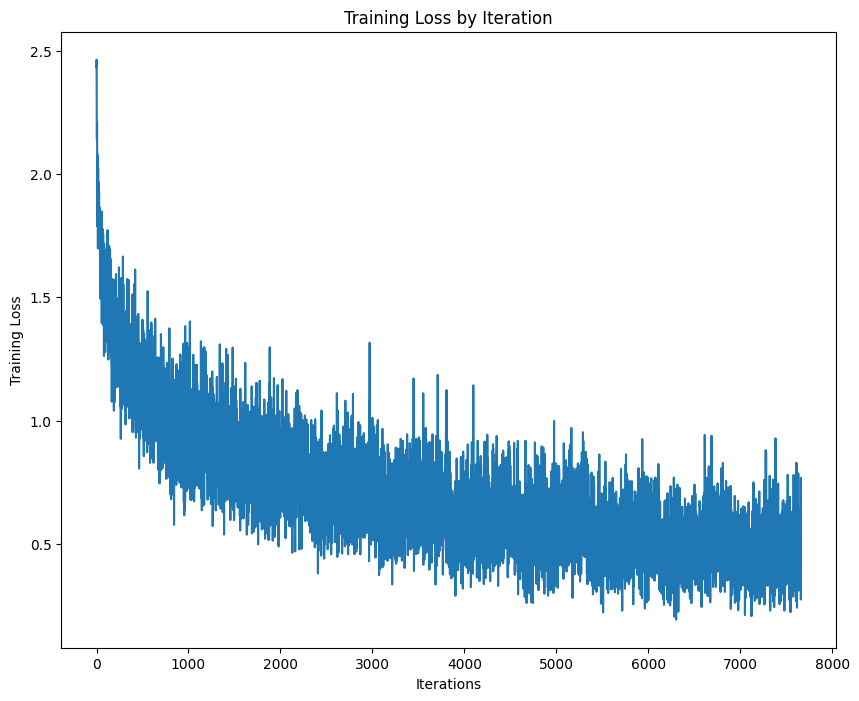

(tensor([0.0770, 0.4550, 0.4900, 0.5480, 0.5270, 0.5150, 0.6160, 0.6340, 0.5840,
         0.6490, 0.6570, 0.6230, 0.6780, 0.6790, 0.6890, 0.6250, 0.6860, 0.6890,
         0.7020, 0.7140, 0.7030, 0.7250, 0.7360, 0.7180, 0.7370, 0.7120, 0.7180,
         0.7330, 0.7090, 0.7350, 0.7250, 0.7410, 0.7290, 0.7330, 0.7210, 0.7410,
         0.7410, 0.7220, 0.7450, 0.7180, 0.7530, 0.7400, 0.7220, 0.7280, 0.7450,
         0.7570, 0.7550, 0.7550, 0.7390, 0.7500, 0.7480, 0.7500, 0.7550, 0.7430,
         0.7450, 0.7700, 0.7370, 0.7530, 0.7590, 0.7490, 0.7420, 0.7670, 0.7650,
         0.7530, 0.7410, 0.7560, 0.7550, 0.7500, 0.7610, 0.7480, 0.7440, 0.7480,
         0.7490, 0.7540, 0.7430, 0.7510, 0.7450]),
 tensor([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
         1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
         2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
         3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4

In [55]:
fix_random_seed(0)
model = None
optimizer = None
################################################################################
# TODO:                                                                        #
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
# Replace "pass" statement with your code
num_classes = 10

learning_rate = 1e-1
momentum = 0.5

model = nn.Sequential(
      nn.LazyConv2d(64, kernel_size=3,padding=1),
      nn.LazyBatchNorm2d(),
      nn.LeakyReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.LazyConv2d(32, kernel_size=5,padding=2),
      nn.LazyBatchNorm2d(),
      nn.LeakyReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.LazyConv2d(16, kernel_size=5,padding=2),
      nn.LazyBatchNorm2d(),
      nn.LeakyReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Flatten(),
      nn.LazyLinear(120),
      nn.LazyBatchNorm1d(),
      nn.LeakyReLU(),

      nn.LazyLinear(84),
      nn.LazyBatchNorm1d(),
      nn.ReLU(),
      nn.LazyLinear(num_classes))

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      weight_decay=1e-4,
                      momentum=momentum, nesterov=True)
# END OF YOUR CODE

# You should get at least 70% accuracy
train_part345(model, optimizer, epochs=10)

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [56]:
best_model = model
acc_final = check_accuracy_part34(loader_test, best_model)


Checking accuracy on test set
Got 7447 / 10000 correct (74.47)
